In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

#outlier detection
from sklearn.ensemble import IsolationForest

#score
from sklearn.metrics import f1_score

# removes warnings in output
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
#import data
training=pd.read_csv('training_data.csv', sep=',')
test=pd.read_csv('songs_to_classify.csv', sep=',')
training.sample(5)

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
196,0.00118,0.659,228253,0.7020,0.000017,0,0.0246,-7.641,0,0.0307,133.439,4,0.6940,1
571,0.95200,0.210,411520,0.0381,0.009730,9,0.0787,-25.335,1,0.0475,84.434,4,0.0546,1
703,0.80500,0.422,187933,0.1650,0.006130,5,0.2710,-20.931,1,0.0385,144.367,3,0.6430,1
206,0.84600,0.222,366773,0.3120,0.391000,5,0.1550,-8.897,1,0.0429,64.773,3,0.1340,1
57,0.68200,0.427,297933,0.3770,0.000000,5,0.1050,-8.136,1,0.0334,125.081,4,0.2450,1


I start by testing my two classification methods, which one that best performs, and then optimize the winner

In [3]:
X, y = training.iloc[:, 0:12], training.iloc[:, 13]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#test all methods
base_estimator = DecisionTreeClassifier()
rng = np.random.RandomState(0)

classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(estimator=base_estimator, n_estimators=1000, learning_rate=1.0, random_state=rng)
    ]

#train and test F1 score
for clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    print(clf, f1)

RandomForestClassifier() 0.8467153284671532
AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=1000,
                   random_state=RandomState(MT19937) at 0x242EEB18A40) 0.8


c:\Users\Jonathan Olsson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


From the above results, we see that RandomForest performs the best. Now it is time for feature selection. Start by plotting all the data from all the features:

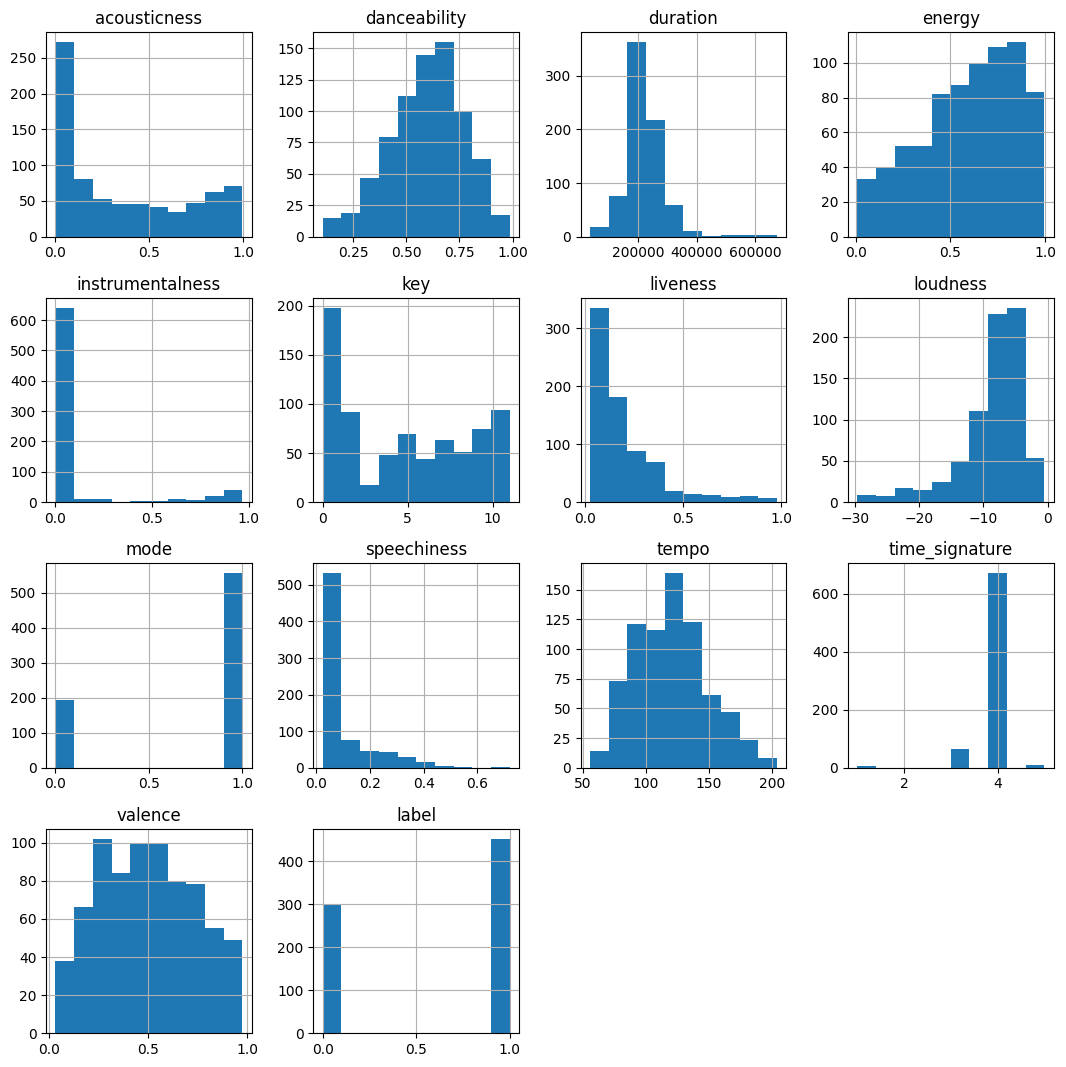

In [4]:
#visualize data
training.hist(figsize=(13,13));

From the above table, time_signature and instrumentalness are prevalent with a specific value throughout the data, and thus doesn't impact predictions. Those features are removed.

In [5]:
#remove time_signature and instrumentalness from the data
feature_selection = [0,1,2,3,5,6,7,8,9,10,12,13]
training = training.iloc[:,feature_selection]
training.sample(5)

,acousticness,danceability,duration,energy,key,liveness,loudness,mode,speechiness,tempo,valence,label
218,0.000459,0.598,194490,0.896,10,0.327,-3.700,0,0.0655,102.043,0.559,0
673,0.150000,0.746,214907,0.848,2,0.370,-4.638,1,0.0331,138.047,0.756,1
466,0.975000,0.213,220600,0.177,0,0.079,-17.848,0,0.0292,89.316,0.384,1
81,0.074400,0.622,348760,0.598,2,0.119,-9.790,1,0.0296,131.183,0.719,1
271,0.554000,0.470,241187,0.625,1,0.924,-9.228,1,0.0680,138.215,0.399,1


RandomForestClassifier has a method that shows importances of features. The features with least importance can be removed

In [6]:
X, y = training.iloc[:, 0:10], training.iloc[:, 11]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

rng = np.random.RandomState(0)
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
print(clf.feature_importances_)

#print the training data for comparison
training

[0.1373169  0.09637151 0.06724201 0.12879028 0.0308307  0.05997401
 0.16347909 0.00655675 0.24853255 0.0609062 ]


,acousticness,danceability,duration,energy,key,liveness,loudness,mode,speechiness,tempo,valence,label
0,0.713000,0.514,100125,0.521,8,0.1120,-14.835,0,0.0444,119.879,0.143,1
1,0.192000,0.714,207019,0.614,4,0.2630,-6.935,1,0.0319,123.969,0.582,1
2,0.333000,0.630,216200,0.455,5,0.1270,-9.290,1,0.0292,139.931,0.199,1
3,0.601000,0.810,136413,0.221,5,0.1840,-11.005,1,0.0429,109.960,0.798,1
4,0.883000,0.465,181440,0.459,6,0.0692,-8.137,0,0.0351,90.807,0.288,1
...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.000175,0.374,333827,0.943,6,0.1250,-4.108,0,0.0556,112.084,0.338,0
746,0.001970,0.487,213000,0.867,10,0.0968,-3.293,0,0.0543,160.048,0.403,0
747,0.916000,0.605,125867,0.314,0,0.3590,-7.631,1,0.0327,138.148,0.836,1
748,0.168000,0.700,249493,0.823,3,0.1220,-6.892,1,0.0373,144.060,0.745,1


We see that mode has very low importance, this feature is removed

In [7]:
feature_selection = [0,1,2,3,4,5,6,8,9,10,11]
training = training.iloc[:,feature_selection]
training.sample(5)

,acousticness,danceability,duration,energy,key,liveness,loudness,speechiness,tempo,valence,label
549,0.3670,0.564,213480,0.756,0,0.438,-4.812,0.0723,154.007,0.658,1
416,0.4570,0.488,141947,0.487,2,0.519,-8.596,0.0432,77.302,0.416,1
298,0.0714,0.763,229640,0.807,1,0.348,-3.714,0.0350,103.038,0.559,0
77,0.3280,0.497,240213,0.661,9,0.211,-9.047,0.0361,180.225,0.894,1
735,0.0190,0.429,184753,0.760,7,0.102,-5.434,0.3270,78.260,0.541,0


The data has alot of outliers that stray away from the rest of the group. At this point, I asked ChatGPT for tips on strategies to detect and remove these outliers. The solution I went for was using IsolationForest.

Text(0.5, 0.98, 'After')

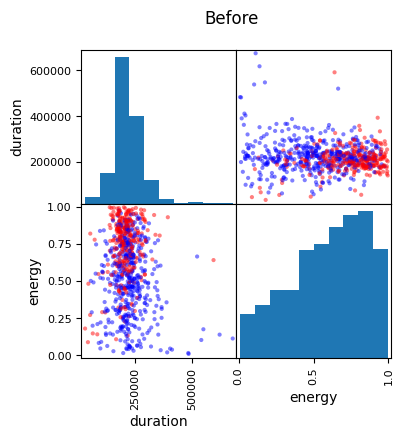

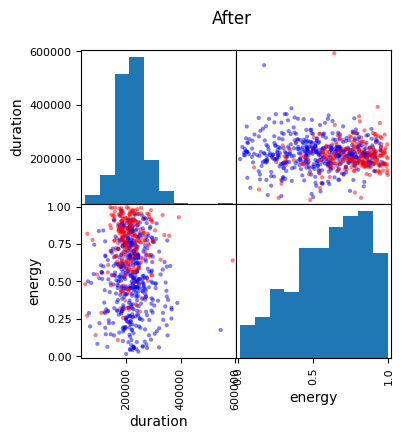

In [8]:
feature_selection = [0,1,2,3,4,5,6,7,8,9]
model = IsolationForest(contamination=0.04, random_state=42,  n_jobs=-1)
outliers = model.fit_predict(training.iloc[:,feature_selection]) #returns an array containing -1 or 1's, indicating outliers or inliners
cleaned_data = training[outliers == 1] #keep only inliers

#plot training data
cols = list(map(lambda x: "red" if x == 0 else "blue", training.iloc[:,10]))
pd.plotting.scatter_matrix(training.iloc[:,2:4], c=cols, figsize=(4, 4));
plt.suptitle('Before')

#plot cleaned data
cols = list(map(lambda x: "red" if x == 0 else "blue", cleaned_data.iloc[:,10]))
pd.plotting.scatter_matrix(cleaned_data.iloc[:,2:4], c=cols, figsize=(4, 4));
plt.suptitle('After')

Now the outliers has been removed, feature selection has been made. It is time to train the model with GridSearch. GridSearch uses k-fold convolution to calculate the best parameters. It is best to find the optimal k-fold for the GridSearch to use in order to get the best parameters from the process

In [9]:
#kfold split

rng = np.random.RandomState(0)
clf = RandomForestClassifier()

n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # k vector

#runs k-fold tests for different k
for splits in n:
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    X, y = training.iloc[:, feature_selection], training.iloc[:,10].values
    for train_index, val_index in kf.split(X):
        X_train, X_val = [X.iloc[i,:] for i in train_index], [X.iloc[i,:] for i in val_index]
        y_train, y_val = [y[i] for i in train_index], [y[i] for i in val_index]
    
    clf.fit(X_train, y_train)
    print(splits, clf.score(X_val, y_val))

2 0.8346666666666667
3 0.836
4 0.8074866310160428
5 0.8
6 0.8
7 0.7850467289719626
8 0.7741935483870968
9 0.7831325301204819
10 0.76
11 0.75
12 0.7580645161290323
13 0.7894736842105263
14 0.6792452830188679
15 0.7
16 0.6956521739130435
17 0.6818181818181818
18 0.7073170731707317
19 0.717948717948718
20 0.7837837837837838


Now we know what k should be used for the GridSearch. Parameter tuning is initiated. This process takes a long time, so i commented out everything. If you want to do the search yourself, go ahead and uncomment this section.

In [11]:
# the optimal parameters are tested
feature_selection = [0,1,2,3,4,5,6,7,8,9]

#splitting validation data (with outliers)
X, y = training.iloc[:, feature_selection], training.iloc[:, 10]
x_dummy, X_val, y_dummy, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

#splitting training data (without outliers)
X, y = cleaned_data.iloc[:, feature_selection], cleaned_data.iloc[:, 10]
X_train, x_dummy, y_train, y_dummy = train_test_split(X, y, test_size=0.30, random_state=42)

rng = np.random.RandomState(0)
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.01, class_weight=None,criterion='gini',max_depth=10, max_features=0.9, max_samples=0.9,min_samples_leaf=2,min_samples_split=5,n_estimators=10000,random_state=rng,warm_start=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
f1 = f1_score(y_val, y_pred)
score = clf.score(X_val, y_val)

print('{0:.4f}'.format(score))
print(f1)

0.8667
0.8928571428571429


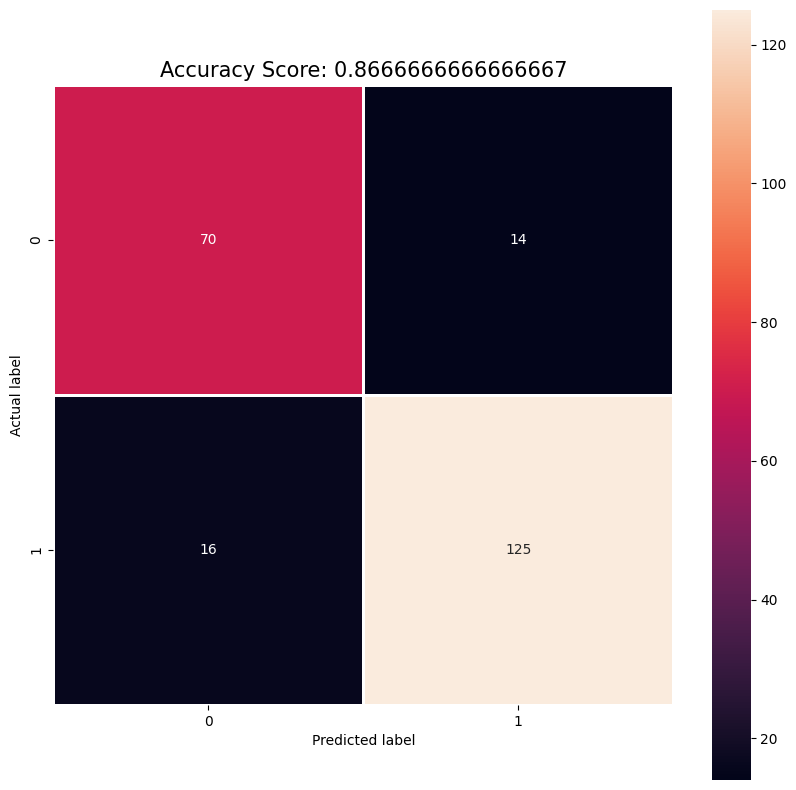

In [12]:
cm = metrics.confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
score = clf.score(X_val, y_val)
plt.title('Accuracy Score: {0}'.format(score), size = 15);

In [13]:
training=pd.read_csv('training_data.csv', sep=',')
training.sample(1)

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
413,0.145,0.595,225813,0.52,0.0,11,0.117,-8.185,0,0.0414,79.95,4,0.369,1


In [14]:
# retrain the model using the whole dataset

feature_selection = [0,1,2,3,5,6,7,9,10,12]

#remove outliers again
model = IsolationForest(contamination=0.04, random_state=42,  n_jobs=-1)
outliers = model.fit_predict(training.iloc[:,feature_selection]) #returns an array containing -1 or 1's, indicating outliers or inliners
training = training[outliers == 1] #keep only inliers

x_train = training.iloc[:,feature_selection]
y_train = training.loc[:,'label'].values

rng = np.random.RandomState(0)
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.01, class_weight=None,criterion='gini',max_depth=10, max_features=0.9, max_samples=0.9,min_samples_leaf=2,min_samples_split=5,n_estimators=10000,random_state=rng,warm_start=False)
clf.fit(x_train, y_train)

RandomForestClassifier(ccp_alpha=0.01, max_depth=10, max_features=0.9,
                       max_samples=0.9, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=10000,
                       random_state=RandomState(MT19937) at 0x242C9704740)

In [15]:
feature_selection = [0,1,2,3,5,6,7,9,10,12]
test = test.iloc[:,feature_selection]
test.sample(1)

,acousticness,danceability,duration,energy,key,liveness,loudness,speechiness,tempo,valence
182,0.0399,0.546,241920,0.733,2,0.235,-7.073,0.0299,107.285,0.91


In [16]:
# now predict the values for the competition
result = clf.predict(test).tolist()
file = open('finalpredictions.txt','w')
for prediction in result:
	file.write(str(prediction))
file.close()